# Machine learning for text classification
---

In [35]:
print(tf.__version__)

2.3.0


In [3]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
# importing a stylesheet library for visualisations from source[1] 
#plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

In [4]:
#from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
#??CountVectorizer

In [5]:
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB

In [6]:
dataframe = pd.read_csv("fake reviews dataset.csv")
dataframe.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [7]:
# no null values
print("number of null values: {}".format(dataframe.isnull().any(axis = 1).sum()))

number of null values: 0


In [8]:
dataframe = dataframe.rename(columns={"text_":"text"})
dataframe = dataframe.drop(["category"], axis=1)

dataframe['text_length_char'] = dataframe.text.apply(len) # character length
dataframe['text_length_word'] = dataframe['text'].apply(lambda x: len(x.split(' ')))

encoder = LabelEncoder()
encoder.fit(dataframe['label'])
dataframe['label_encoded'] = encoder.transform(dataframe['label'])

dataframe.head()
#df.label = df.label.apply(lambda v: 0 if v == "ham" else 1)

,rating,label,text,text_length_char,text_length_word,label_encoded
0,5.0,CG,"Love this! Well made, sturdy, and very comfor...",75,14,0
1,5.0,CG,"love it, a great upgrade from the original. I...",80,17,0
2,5.0,CG,This pillow saved my back. I love the look and...,67,14,0
3,1.0,CG,"Missing information on how to use it, but it i...",81,18,0
4,5.0,CG,Very nice set. Good quality. We have had the s...,85,18,0


In [34]:
dataframe['text'][4]

'Very nice set. Good quality. We have had the set for two months now and have not been'

In [9]:
dataframe['label'].value_counts() # balanced

CG    20216
OR    20216
Name: label, dtype: int64

<AxesSubplot:xlabel='label', ylabel='count'>

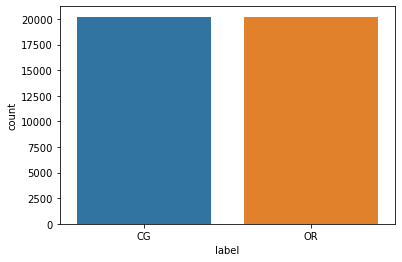

In [10]:
#dataframe['label'].value_counts().plot(kind='bar')
sns.countplot(x = dataframe.label)
#plt.xlabel("label")

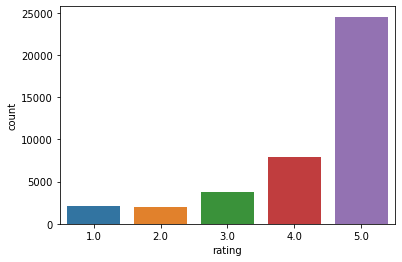

In [11]:
sns.countplot(x = dataframe.rating);

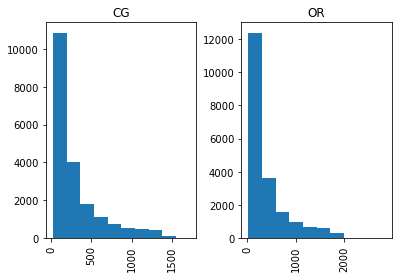

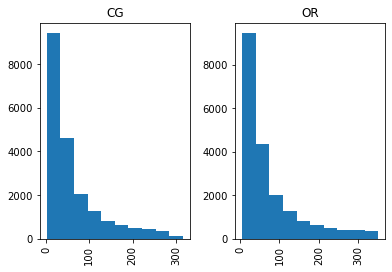

In [12]:
dataframe.hist(column='text_length_char', by='label');
dataframe.hist(column='text_length_word', by='label');
# spruce up? https://dataindependent.com/pandas/pandas-histogram-dataframe-hist/
# could do boxplots instead

In [13]:
print(max(dataframe['text_length_char']))
print(max(dataframe['text_length_word']))

2827
351


In [14]:
wc = WordCloud(
    background_color='white', 
    max_words=50)

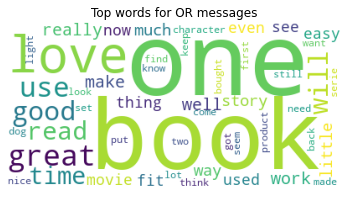

In [15]:
wc.generate(' '.join(text for text in dataframe.loc[dataframe['label'] == 'OR', 'text']))
plt.title('Top words for OR messages')
plt.imshow(wc)
plt.axis("off");

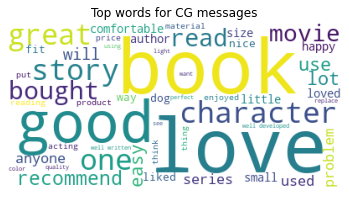

In [16]:
wc.generate(' '.join(text for text in dataframe.loc[dataframe['label'] == 'CG', 'text']))
plt.title('Top words for CG messages')
plt.imshow(wc)
plt.axis("off");

In [17]:
x = dataframe["text"]
y = dataframe["label_encoded"] # or label encoded

In [18]:
# why to use train test split and stratify: https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=420, shuffle=True, stratify=y)

In [19]:
print(len(x_train))
print(len(y_train))

print(len(x_test))
print(len(y_test))

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
# not needed for scikit learn
#x_train, x_val, y_train, y_val = train_test_split(x_train, y, test_size=0.2, random_state=420, shuffle=True, stratify=y)

32345
32345
8087
8087
(32345,) (8087,) (32345,) (8087,)


## ml models

In [20]:
print(tf.__version__)

2.3.0


In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional, GlobalAveragePooling1D

In [22]:
vocab_size = 5000 # make the top list of words (common words)
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # OOV = Out of Vocabulary

In [23]:
#https://www.youtube.com/watch?v=Y_hzMnRXjhI&list=PLQY2H8rRoyvzDbLUZkbudP-MFQZwNmU4S&index=3
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train) # only fit to training data
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(x_train)

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(x_test)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(train_padded[0])
print(train_padded.shape)

[   9   14  260    5  101   11   49 4136  566   60    4 3865   12    1
    5    3   14  666    7  190   13    2  481    8   18  128    2  833
    8    4   73 2405  262   19   31   20  128    2  481    8   18  501
   19    3  100  192   39   75  293    4  350  481   16    4  833  402
   33   18  132   16    4  833   45    6   84    4   92   51 2405    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [25]:
n_lstm = 20
drop_lstm =0.2

model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True, activation='relu'))# return=true to return sequences rather
# than something flat. only needed when another recuureent layer (not needed when dense layer)
model1.add(LSTM(n_lstm, dropout=drop_lstm, activation='relu')) 
model1.add(Dense(1, activation='sigmoid'))

model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [26]:
history = model1.fit(train_padded, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
118/809 [===>..........................] - ETA: 2:01 - loss: 0.9074 - accuracy: 0.5998

KeyboardInterrupt: 

In [29]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    #tf.keras.layers.GlobalAveragePooling1D(), # could add a conv layer too if you wanted 
    tf.keras.layers.Bidirectional(LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
history = model.fit(train_padded, y_train, epochs=10, validation_split=0.2, batch_size=64)

Epoch 1/10
405/405 [==============================] - 134s 331ms/step - loss: 0.1864 - accuracy: 0.9261 - val_loss: 0.1487 - val_accuracy: 0.9419
Epoch 2/10
405/405 [==============================] - 139s 342ms/step - loss: 0.1103 - accuracy: 0.9598 - val_loss: 0.1442 - val_accuracy: 0.9516
Epoch 3/10
405/405 [==============================] - 143s 352ms/step - loss: 0.0704 - accuracy: 0.9737 - val_loss: 0.1405 - val_accuracy: 0.9487
Epoch 4/10
405/405 [==============================] - 141s 348ms/step - loss: 0.0448 - accuracy: 0.9845 - val_loss: 0.1594 - val_accuracy: 0.9499
Epoch 5/10
405/405 [==============================] - 154s 380ms/step - loss: 0.0308 - accuracy: 0.9899 - val_loss: 0.2020 - val_accuracy: 0.9440
Epoch 6/10
405/405 [==============================] - 157s 389ms/step - loss: 0.0243 - accuracy: 0.9917 - val_loss: 0.1903 - val_accuracy: 0.9505
Epoch 7/10
405/405 [==============================] - 138s 342ms/step - loss: 0.0170 - accuracy: 0.9942 - val_loss: 0.2286 -

In [32]:
model.evaluate(test_padded, y_test)

253/253 [==============================] - 14s 55ms/step - loss: 0.2277 - accuracy: 0.9507


[0.22768890857696533, 0.9506615400314331]

In [20]:
top_words = 5000
# truncate and pad input sequences
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, epochs=3, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

ModuleNotFoundError: No module named 'tf'

## deep learning

In [32]:
%%time
def naive(n, smoothing):
    # https://kavita-ganesan.com/how-to-use-countvectorizer/
    cv = CountVectorizer(ngram_range=(n,n)) #, stop_words="english", analyzer='char_wb' ref scikit learn documentation
    train_features = cv.fit_transform(x_train)
    test_features = cv.transform(x_test)

    NB = MultinomialNB(alpha=smoothing)
    NB.fit(train_features, y_train)

    #pred = NB.predict(test_features)
    #score = metrics.accuracy_score(y_test, pred)
    #print(score)
    
    ## return here instead 
    print("accuracy is: ", NB.score(test_features, y_test))

    #cm = metrics.confusion_matrix(y_test, pred)
    #print(cm)

CPU times: total: 0 ns
Wall time: 0 ns


In [33]:
%%time
ngrams = [1,2,3]
laplaces = [0.1, 1, 10]
#counts
for i in ngrams:
    for j in laplaces:
        print("ngrams: {} | laplace value: {}.".format(i, j))
        naive(i, j)

ngrams: 1 | laplace value: 0.1.
accuracy is:  0.8678125386422654
ngrams: 1 | laplace value: 1.
accuracy is:  0.8628663286756523
ngrams: 1 | laplace value: 10.
accuracy is:  0.849882527513293
ngrams: 2 | laplace value: 0.1.
accuracy is:  0.8968715221961172
ngrams: 2 | laplace value: 1.
accuracy is:  0.854086805984914
ngrams: 2 | laplace value: 10.
accuracy is:  0.7858291084456536
ngrams: 3 | laplace value: 0.1.
accuracy is:  0.8169902312353159
ngrams: 3 | laplace value: 1.
accuracy is:  0.7367379745270187
ngrams: 3 | laplace value: 10.
accuracy is:  0.6475825398788179
CPU times: total: 46.3 s
Wall time: 46.4 s


In [ ]:
# do fake and real reviews have the same legnth and polarity distribtuin. check word counts for each 
#do +ve and -ve reviews have the same length and dist
# wordclouds for fake and real 